In [ ]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import random

dataset_path = "/content/drive/MyDrive/NNDL/PlantVillage"
categories = os.listdir(dataset_path)
print("Categories:", categories)

for category in categories:
    files = os.listdir(os.path.join(dataset_path, category))
    print(f"{category}: {len(files)} images")
    print("Sample:", os.path.join(dataset_path, category, random.choice(files)))


Categories: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight']
Pepper__bell___Bacterial_spot: 997 images
Sample: /content/drive/MyDrive/NNDL/PlantVillage/Pepper__bell___Bacterial_spot/caa7bde5-3d2d-484c-8c71-607b4b1041f8___JR_B.Spot 8870.JPG
Pepper__bell___healthy: 1478 images
Sample: /content/drive/MyDrive/NNDL/PlantVillage/Pepper__bell___healthy/0d4e35c0-f6d6-4810-9522-14e1d491a05d___JR_HL 8673.JPG
Potato___Early_blight: 1000 images
Sample: /content/drive/MyDrive/NNDL/PlantVillage/Potato___Early_blight/2c0e712a-fb21-44b6-bbe1-7c67cec7b965___RS_Early.B 7084.JPG
Potato___Late_blight: 1000 images
Sample: /content/drive/MyDrive/NNDL/PlantVillage/Potato___Late_blight/a6f75dd1-c290-4116-be6a-e3c94e40aa2a___RS_LB 3265.JPG
Potato___healthy: 152 images
Sample: /content/drive/MyDrive/NNDL/PlantVillage/Potato___healthy/22322780-95b4-4b45-b626-26b229

![Alt text](image-1-2.png)

In [ ]:
from PIL import Image

def crop_center(image, cropx, cropy):
    width, height = image.size
    left = (width - cropx) // 2
    top = (height - cropy) // 2
    right = left + cropx
    bottom = top + cropy
    return image.crop((left, top, right, bottom))

Gray Scaling


In [ ]:
#Prepare Data (grayscale + resize)
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

IMG_SIZE = 128

def load_images(path):
    X, y = [], []
    label_map = {label: i for i, label in enumerate(sorted(os.listdir(path)))}

    for label in os.listdir(path):
        folder_path = os.path.join(path, label)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path).convert("L")  # grayscale
            img = crop_center(img, IMG_SIZE, IMG_SIZE)
            img = img.resize((IMG_SIZE, IMG_SIZE))
            X.append(np.array(img))
            y.append(label_map[label])

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    y = to_categorical(y)
    return X, y

X, y = load_images(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


![Alt text](image.png)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


# 3 layer Conv2D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2359 - loss: 2.0390

267/267 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.2362 - loss: 2.0384 - val_accuracy: 0.3850 - val_loss: 1.7165
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3981 - loss: 1.6792

267/267 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.3982 - loss: 1.6789 - val_accuracy: 0.5014 - val_loss: 1.3812
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4615 - loss: 1.4839

267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4616 - loss: 1.4837 - val_accuracy: 0.5305 - val_loss: 1.2512
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.5168 - loss: 1.3503 - val_accuracy: 0.5366 - val_loss: 1.3588
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5539 - loss: 1.2731

267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.5539 - loss: 1.2731 - val_accuracy: 0.6300 - val_loss: 1.0720
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.5874 - loss: 1.1682 - val_accuracy: 0.6221 - val_loss: 1.0923
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.6030 - loss: 1.1127 - val_accuracy: 0.5620 - val_loss: 1.4038
Epoch 8/10
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6240 - loss: 1.0513

267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6239 - loss: 1.0515 - val_accuracy: 0.6498 - val_loss: 1.0233
Epoch 9/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.6278 - loss: 1.0339 - val_accuracy: 0.6085 - val_loss: 1.2044
Epoch 10/10
266/267 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6285 - loss: 1.0283

267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.6286 - loss: 1.0282 - val_accuracy: 0.6657 - val_loss: 0.9742


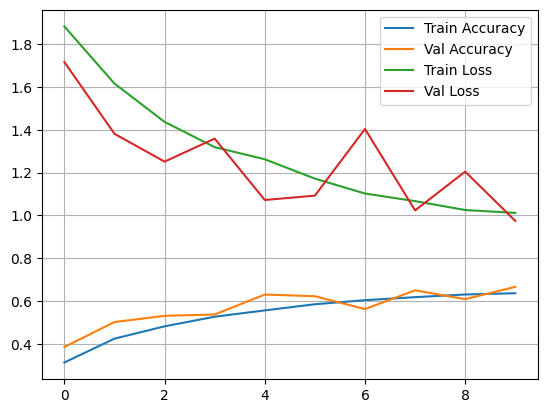

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6784 - loss: 0.9329
Test Loss: 0.9742
Test Accuracy: 0.6657


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
labels = sorted(os.listdir(dataset_path))

print(classification_report(y_true, y_pred, target_names=labels))


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.66      0.71      0.68       205
       Pepper__bell___healthy       0.72      0.84      0.77       285
        Potato___Early_blight       0.53      0.96      0.69       216
         Potato___Late_blight       0.43      0.42      0.43       202
             Potato___healthy       1.00      0.04      0.07        28
        Tomato_Bacterial_spot       0.84      0.78      0.81       419
          Tomato_Early_blight       0.64      0.39      0.48       184
           Tomato_Late_blight       0.68      0.66      0.67       394
             Tomato_Leaf_Mold       0.77      0.43      0.55       190
    Tomato_Septoria_leaf_spot       0.00      0.00      0.00         7

                     accuracy                           0.67      2130
                    macro avg       0.63      0.52      0.51      2130
                 weighted avg      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


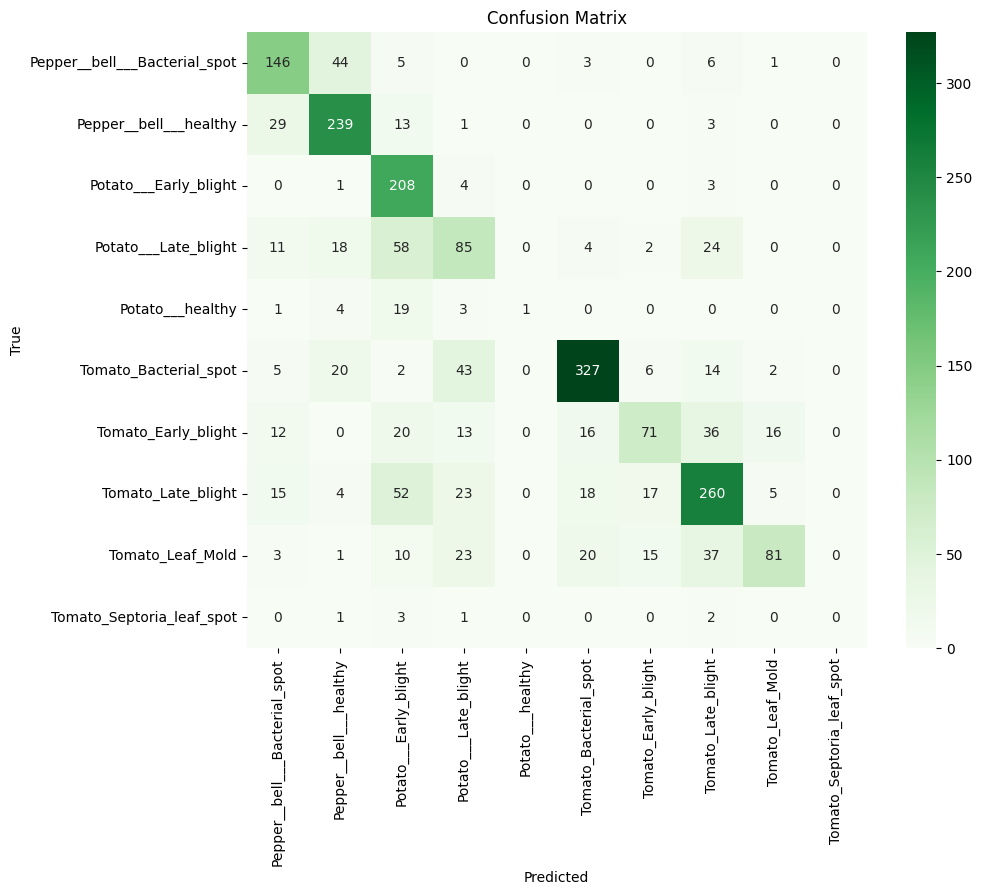

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


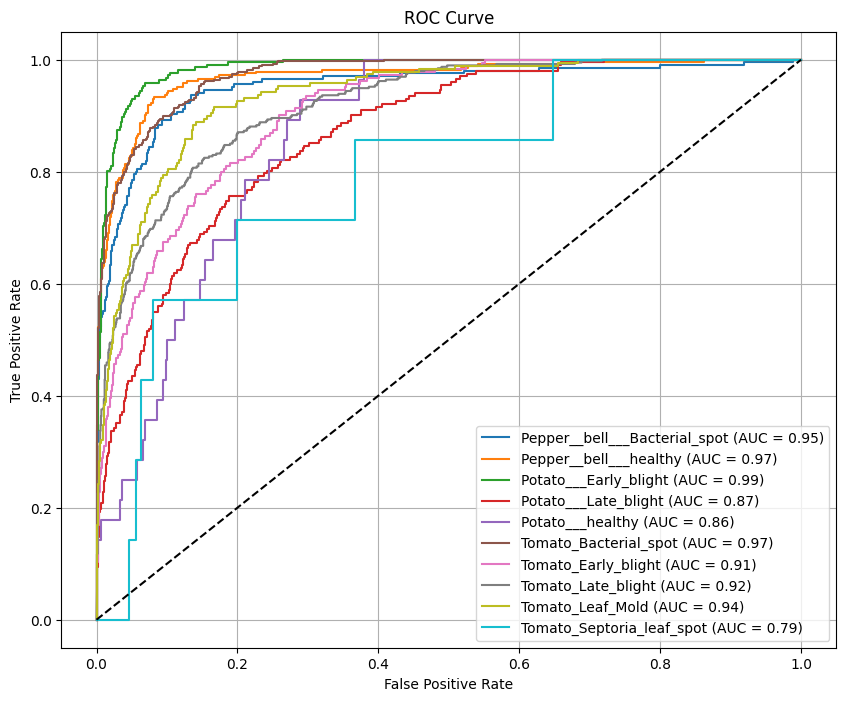

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_true, classes=range(len(labels)))
y_score = model.predict(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
